# 1. Setup
1. Import libraries
2. Import data
3. Basic data cleaning

In [2]:
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
import sqlite3
# import numpy as np
import string
%matplotlib inline

box_office = pd.read_csv(
    '/Users/ronlodetti/Documents/Flatiron/1_phase/Project_1/Movie_Analysis_Project/data/imported/tn.movie_budgets.csv.gz')
conn = sqlite3.connect(
    '/Users/ronlodetti/Documents/Flatiron/1_phase/Project_1/Movie_Analysis_Project/data/imported/im.db')
q = """
SELECT 
    movie_id,
    primary_title AS title,
    start_year AS year,
    runtime_minutes AS runtime,
    primary_name AS producer,
    genres
FROM movie_basics 
JOIN principals
    USING('movie_id')
JOIN persons
    USING('person_id')
WHERE job == 'producer'
;
"""
imdb = pd.read_sql(q, conn)

from my_package import data_prep as dp

box_office = dp.prep_box_office(box_office)
imdb = dp.prep_imdb(imdb)
movies = dp.merge(box_office,imdb)
movies = dp.add_features(movies)

In [19]:
prod_ranked = movies.dropna(axis=0, subset=['producer_rank'])

In [25]:
prod_ranked.drop_duplicates('movie_id').groupby('producer_rank').median()

,year,budget,worldwide_gross,runtime,ROI
producer_rank,,,,,
High ROI Producers,2015,5000000,91266581,99.0,1080.879909
Low ROI Producers,2013,36000000,48425971,113.0,26.704591


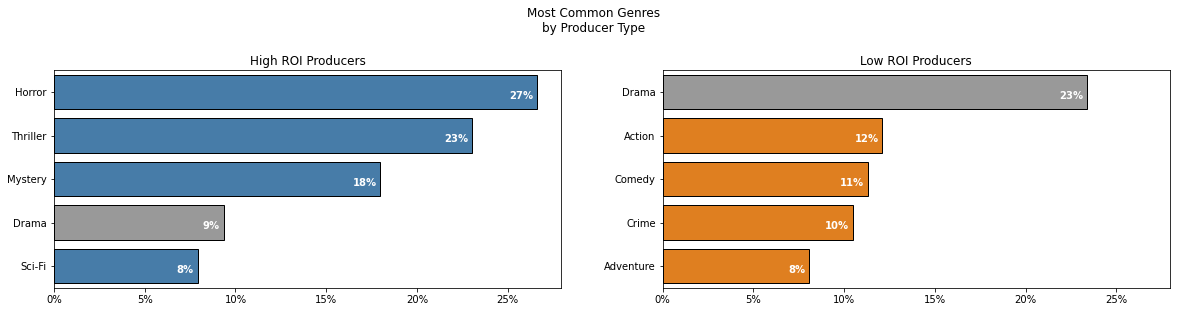

In [129]:
genres = movies.dropna(axis=0, subset=['producer_rank']).drop_duplicates(
        ['movie_id', 'genres'])
top_gen = genres[genres['producer_rank'] == 'High ROI Producers']
bot_gen = genres[genres['producer_rank'] == 'Low ROI Producers']
df1 = top_gen['genres'].value_counts(normalize=True)[:5]
df2 = bot_gen['genres'].value_counts(normalize=True)[:5]

hlabels = list(df1.map(lambda x: "{:.0%}".format(x)))
llabels = list(df2.map(lambda x: "{:.0%}".format(x)))

colors = {'Horror': '#377eb8', 'Thriller': '#377eb8', 'Mystery': '#377eb8', 'Drama': '#999999',
          'Sci-Fi': '#377eb8', 'Action': '#ff7f00', 'Comedy': '#ff7f00', 'Crime': '#ff7f00', 'Adventure': '#ff7f00'}

fig, ax = plt.subplots(1, 2, figsize=(20, 4), sharex=True)
high = sns.barplot(y=df1.index, x=df1.values,
                   ax=ax[0], edgecolor='black', palette=colors)
low = sns.barplot(y=df2.index, x=df2.values,
                  ax=ax[1], edgecolor='black', palette=colors)
high.set_title('High ROI Producers')
low.set_title('Low ROI Producers')
fig.suptitle('Most Common Genres\nby Producer Type', y=1.1)
patches = high.patches
for i in range(len(patches)):
    x = patches[i].get_x()+patches[i].get_width()-.002
    y = patches[i].get_y()+0.55
    high.text(x, y, hlabels[i], c='white', weight='bold', ha='right')

patches1 = low.patches
for i in range(len(patches1)):
    x = patches1[i].get_x()+patches1[i].get_width()-0.002
    y = patches1[i].get_y()+0.55
    low.text(x, y, llabels[i], c='white', weight='bold', ha='right')

high.xaxis.set_major_formatter(lambda x, pos: "{:.0%}".format(x))

''

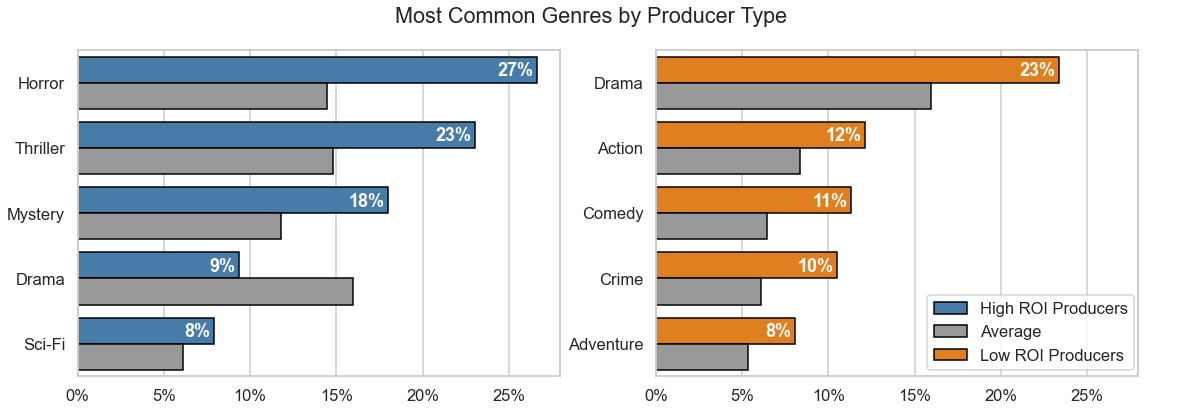

In [243]:
genres = movies.dropna(axis=0, subset=['producer_rank']).drop_duplicates(
        ['movie_id', 'genres'])
top_gen = genres[genres['producer_rank'] == 'High ROI Producers']
bot_gen = genres[genres['producer_rank'] == 'Low ROI Producers']
s1 = top_gen['genres'].value_counts(normalize=True)[:5]
s2 = bot_gen['genres'].value_counts(normalize=True)[:5]
s3 = genres['genres'].value_counts(normalize=True)
s4 = pd.Series([s3[i] for i in list(s1.index)],index=list(s1.index))
s5 = pd.Series([s3[i] for i in list(s2.index)],index=list(s2.index))
df1 = pd.concat([s1,s4],axis=1).reset_index().rename(columns={'index':'genre','genres':'High ROI Producers',0:'Average'}).melt('genre')
df2 = pd.concat([s2,s5],axis=1).reset_index().rename(columns={'index':'genre','genres':'Low ROI Producers',0:'Average'}).melt('genre')

s1_list = list(s1.map(lambda x: "{:.0%}".format(x)))
s2_list = list(s2.map(lambda x: "{:.0%}".format(x)))
colors = {'High ROI Producers': '#377eb8', 'Average': '#999999', 'Low ROI Producers': '#ff7f00'}
sns.set_context('talk')
sns.set_style('whitegrid')
fig, ax = plt.subplots(1, 2, figsize=(19, 6), sharex=True)

high = sns.barplot(data = df1, y='genre', x='value', hue='variable',ax=ax[0], edgecolor='black', palette=colors)
low = sns.barplot(data = df2, y='genre', x='value', hue='variable',ax=ax[1], edgecolor='black', palette=colors)

patches = high.patches
for i in range(5):
    x = patches[i].get_x()+patches[i].get_width()-.002
    y = patches[i].get_y()+(patches[i].get_height()/1.35)
    high.text(x, y, s1_list[i], c='white', weight='bold', ha='right')

patches1 = low.patches
for i in range(5):
    x = patches1[i].get_x()+patches1[i].get_width()-0.002
    y = patches1[i].get_y()+(patches[i].get_height()/1.35)
    low.text(x, y, s2_list[i], c='white', weight='bold', ha='right')

fig.suptitle('Most Common Genres by Producer Type')
high.xaxis.set_major_formatter(lambda x, pos: "{:.0%}".format(x))
high.set(ylabel=None,xlabel=None)
low.set(ylabel=None,xlabel=None)

ax[0].legend([],[], frameon=False)
ax[1].legend([],[], frameon=False)
handles, labels = ax[0].get_legend_handles_labels()
handles.append(ax[1].get_legend_handles_labels()[0][0])
labels.append(ax[1].get_legend_handles_labels()[1][0])
fig.legend(handles, labels,loc=(0.78,0.1))
;


In [244]:
def producer_genre(df):
    genres = df.dropna(axis=0, subset=['producer_rank']).drop_duplicates(
        ['movie_id', 'genres'])
    top_gen = genres[genres['producer_rank'] == 'High ROI Producers']
    bot_gen = genres[genres['producer_rank'] == 'Low ROI Producers']
    s1 = top_gen['genres'].value_counts(normalize=True)[:5]
    s2 = bot_gen['genres'].value_counts(normalize=True)[:5]
    s3 = genres['genres'].value_counts(normalize=True)
    s4 = pd.Series([s3[i] for i in list(s1.index)],index=list(s1.index))
    s5 = pd.Series([s3[i] for i in list(s2.index)],index=list(s2.index))
    df1 = pd.concat([s1,s4],axis=1).reset_index().rename(columns={'index':'genre','genres':'High ROI Producers',0:'Average'}).melt('genre')
    df2 = pd.concat([s2,s5],axis=1).reset_index().rename(columns={'index':'genre','genres':'Low ROI Producers',0:'Average'}).melt('genre')

    s1_list = list(s1.map(lambda x: "{:.0%}".format(x)))
    s2_list = list(s2.map(lambda x: "{:.0%}".format(x)))
    colors = {'High ROI Producers': '#377eb8', 'Average': '#999999', 'Low ROI Producers': '#ff7f00'}
    sns.set_context('talk')
    sns.set_style('whitegrid')
    fig, ax = plt.subplots(1, 2, figsize=(19, 6), sharex=True)

    high = sns.barplot(data = df1, y='genre', x='value', hue='variable',ax=ax[0], edgecolor='black', palette=colors)
    low = sns.barplot(data = df2, y='genre', x='value', hue='variable',ax=ax[1], edgecolor='black', palette=colors)

    patches = high.patches
    for i in range(5):
        x = patches[i].get_x()+patches[i].get_width()-.002
        y = patches[i].get_y()+(patches[i].get_height()/1.35)
        high.text(x, y, s1_list[i], c='white', weight='bold', ha='right')

    patches1 = low.patches
    for i in range(5):
        x = patches1[i].get_x()+patches1[i].get_width()-0.002
        y = patches1[i].get_y()+(patches[i].get_height()/1.35)
        low.text(x, y, s2_list[i], c='white', weight='bold', ha='right')

    fig.suptitle('Most Common Genres by Producer Type')
    high.xaxis.set_major_formatter(lambda x, pos: "{:.0%}".format(x))
    high.set(ylabel=None,xlabel=None)
    low.set(ylabel=None,xlabel=None)

    ax[0].legend([],[], frameon=False)
    ax[1].legend([],[], frameon=False)
    handles, labels = ax[0].get_legend_handles_labels()
    handles.append(ax[1].get_legend_handles_labels()[0][0])
    labels.append(ax[1].get_legend_handles_labels()[1][0])
    fig.legend(handles, labels,loc=(0.78,0.1))

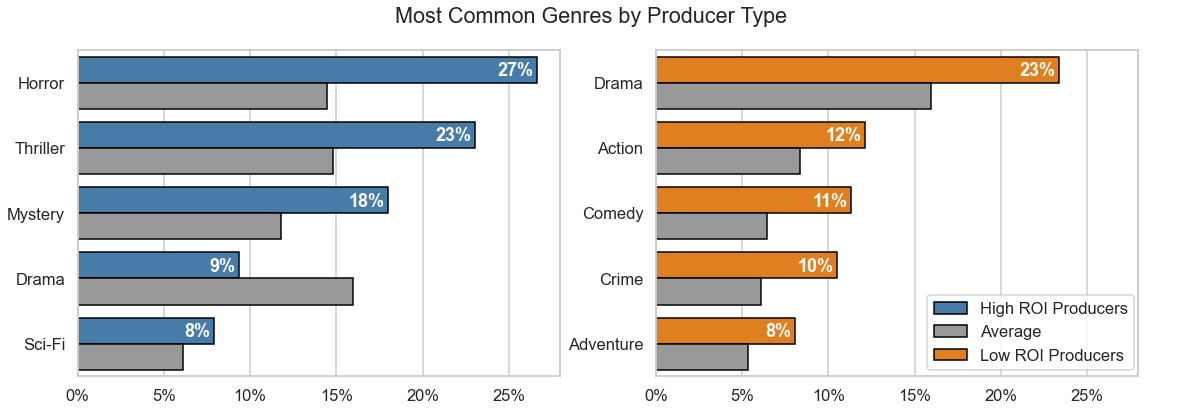

In [245]:
producer_genre(movies)

## Feature Engineering

In [13]:
genres = movies.dropna(axis=0, subset=['producer_rank']).drop_duplicates(
        ['movie_id', 'genres'])
top_gen = genres[genres['producer_rank'] == 'High ROI Producers']
bot_gen = genres[genres['producer_rank'] == 'Low ROI Producers']
s1 = top_gen['genres'].value_counts(normalize=True,sort=False).reset_index()
s2 = bot_gen['genres'].value_counts(normalize=True,sort=False).reset_index()
s3 = genres['genres'].value_counts(normalize=True,sort=False).reset_index()

In [18]:
test1 = pd.merge(s1,s3,how='outer',on='index')
test1['diff'] = test1['genres_x']-test1['genres_y']
high_t =  test1.sort_values('diff',ascending=False)

In [19]:
test2 = pd.merge(s2,s3,how='outer',on='index')
test2['diff'] = test2['genres_x']-test2['genres_y']
low_t =  test2.sort_values('diff',ascending=False)

In [20]:
low_t

,index,genres_x,genres_y,diff
11,Drama,0.233871,0.159696,0.074175
1,Comedy,0.112903,0.064639,0.048264
2,Crime,0.104839,0.060837,0.044002
10,Action,0.120968,0.083650,0.037318
6,Adventure,0.080645,0.053232,0.027413
7,Romance,0.040323,0.019011,0.021311
8,Biography,0.040323,0.022814,0.017509
4,Family,0.032258,0.019011,0.013247
14,Fantasy,0.016129,0.007605,0.008524
5,History,0.016129,0.007605,0.008524


In [71]:
sns.color_palette('CMRmap')

[(0.16941176470588235, 0.15, 0.5323529411764706),
 (0.3870588235294118, 0.16450980392156864, 0.6774509803921569),
 (0.7678431372549019, 0.22098039215686274, 0.3531372549019608),
 (0.9419607843137255, 0.3950980392156863, 0.06294117647058822),
 (0.9, 0.6774509803921569, 0.07098039215686275),
 (0.9, 0.8805882352941177, 0.44823529411764707)]

In [72]:
sns.color_palette('Paired')

[(0.6509803921568628, 0.807843137254902, 0.8901960784313725),
 (0.12156862745098039, 0.47058823529411764, 0.7058823529411765),
 (0.6980392156862745, 0.8745098039215686, 0.5411764705882353),
 (0.2, 0.6274509803921569, 0.17254901960784313),
 (0.984313725490196, 0.6039215686274509, 0.6),
 (0.8901960784313725, 0.10196078431372549, 0.10980392156862745),
 (0.9921568627450981, 0.7490196078431373, 0.43529411764705883),
 (1.0, 0.4980392156862745, 0.0),
 (0.792156862745098, 0.6980392156862745, 0.8392156862745098),
 (0.41568627450980394, 0.23921568627450981, 0.6039215686274509),
 (1.0, 1.0, 0.6),
 (0.6941176470588235, 0.34901960784313724, 0.1568627450980392)]

In [73]:
pal = sns.color_palette('Set1')

[(0.8941176470588236, 0.10196078431372549, 0.10980392156862745),
 (0.21568627450980393, 0.49411764705882355, 0.7215686274509804),
 (0.30196078431372547, 0.6862745098039216, 0.2901960784313726),
 (0.596078431372549, 0.3058823529411765, 0.6392156862745098),
 (1.0, 0.4980392156862745, 0.0),
 (1.0, 1.0, 0.2),
 (0.6509803921568628, 0.33725490196078434, 0.1568627450980392),
 (0.9686274509803922, 0.5058823529411764, 0.7490196078431373),
 (0.6, 0.6, 0.6)]

In [83]:
pal = sns.color_palette('Set1')
pal.as_hex()[8]

'#999999'

In [ ]:
sns.color_palette('Spectral')

In [ ]:
sns.color_palette('gist_rainbow')

In [ ]:
sns.color_palette('tab10')

In [ ]:
sns.color_palette('tab20')

In [ ]:
sns.color_palette('turbo')